In [7]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import streamlit as st


In [ ]:
# Connect to your SQL database
username = "root"
db_pass = "****"
hostname = "localhost"
port = "3306"
db_name = "aviation_db"

engine = create_engine(f"mysql+pymysql://{username}:{db_pass}@{hostname}:{port}/{db_name}")

# Query to load flights table
query_flights = "SELECT * FROM flights_v2;"

# Load as a DataFrame
flights_df = pd.read_sql(query_flights, engine)

In [9]:
flights_df.head()

,flight_date,flight_number,flight_status,airline,dep_airport,dep_timezone,dep_iata,dep_delay,scheduled_departure_datetime,scheduled_departure_datetime_date,...,arr_delay,scheduled_arrival_datetime,scheduled_arrival_datetime_date,scheduled_arrival_datetime_time,actual_arrival_datetime,arr_latitude,arr_longitude,arr_country,arr_city,arr_state
0,2025-06-01,8970,pending update,Delta Air Lines,Hartsfield-jackson Atlanta International,America/New_York,ATL,10.0,2025-06-01 17:00:00,2025-06-01,...,-10.0,2025-06-01 17:26:00,2025-06-01,17:26:00,NaT,32.500000,-93.666664,US,Bossier City,Louisiana
1,2025-06-01,3594,pending update,Delta Air Lines,Hartsfield-jackson Atlanta International,America/New_York,ATL,6.0,2025-06-01 09:34:00,2025-06-01,...,-8.0,2025-06-01 10:25:00,2025-06-01,10:25:00,NaT,32.445112,-93.826737,US,Shreveport,Louisiana
2,2025-06-01,3033,pending update,Delta Air Lines,Hartsfield-jackson Atlanta International,America/New_York,ATL,16.0,2025-06-01 08:10:00,2025-06-01,...,-12.0,2025-06-01 08:43:00,2025-06-01,08:43:00,NaT,34.727432,-92.221375,US,North Little Rock,Arkansas
3,2025-06-01,3147,landed,Delta Air Lines,Hartsfield-jackson Atlanta International,America/New_York,ATL,9.0,2025-06-01 09:40:00,2025-06-01,...,-11.0,2025-06-01 10:36:00,2025-06-01,10:36:00,2025-06-01 10:25:00,34.895446,-82.217228,US,Greer,South Carolina
4,2025-06-01,9937,cancelled,Delta Air Lines,Hartsfield-jackson Atlanta International,America/New_York,ATL,23.0,2025-06-01 00:15:00,2025-06-01,...,-10.0,2025-06-01 01:15:00,2025-06-01,01:15:00,NaT,32.845023,-96.849841,US,University Park,Texas


In [10]:
flights_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194237 entries, 0 to 194236
Data columns (total 30 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   flight_date                        194237 non-null  datetime64[ns]
 1   flight_number                      194152 non-null  object        
 2   flight_status                      194237 non-null  object        
 3   airline                            194237 non-null  object        
 4   dep_airport                        194237 non-null  object        
 5   dep_timezone                       194237 non-null  object        
 6   dep_iata                           194237 non-null  object        
 7   dep_delay                          194237 non-null  float64       
 8   scheduled_departure_datetime       114568 non-null  datetime64[ns]
 9   scheduled_departure_datetime_date  114568 non-null  object        
 10  scheduled_departure_

In [11]:
def fill_missing_arr(flights_df: pd.DataFrame, fill_column: str, iata_column: str, iata_codes: list, name_list:list):
    """ 
    Fills in missing arrival location details e.g. `arr_airport`, `arr_city` using IATA codes
    Parameters:
        flights_df: flights_df dataframe
        fill_column: column name containing missing data 
        iata_column: column with IATA codes to map from (e.g. "arr_iata" or "dep_iata")
        iata_codes: list of iata codes that correspond to the missing data from the fill_column
        name_list: names to fill the missing values in the fill_column, ordered to match the corresponding IATA codes.
    Return:
        Updated dataframe with missing values filled in
    """
    
    flights_copy = flights_df.copy()

    code_name = {code: name for code, name in zip(iata_codes, name_list)}
    flights_copy[fill_column] = flights_copy[fill_column].fillna(flights_df[iata_column].map(code_name))

    return flights_copy


# Obtain the list of all arr_iata with missing airport names
missing_airports = flights_df[flights_df["arr_airport"].isna()]
ma_airport_codes = missing_airports["arr_iata"].unique()
print("IATA codes corresponding to missing arrival airport names:", ma_airport_codes)

airport_names = airport_names = [
    "Barksdale Air Force Base Airport",
    "Ian Fleming International Airport",
    "Comayagua International Airport (Palmerola / Soto Cano Air Base)",
    "Cecil Airport",
    "Joint Base Andrews (Andrews Air Force Base)"
]

# Fill missing info
flights_df = fill_missing_arr(flights_df, "arr_airport", "arr_iata", ma_airport_codes, airport_names)

# Obtain the list of all arr_iata with missing city names
missing_cities = flights_df[flights_df["arr_city"].isna()]
mac_airport_codes = missing_cities["arr_iata"].unique()
print("IATA codes corresponding to missing arrival city names:", mac_airport_codes)

arr_city_names = [
    "Fort Lauderdale", "Washington", "Charlotte", "Columbia", "Houston", 
    "Las Vegas", "Augusta", "Montgomery", "Rochester", "Oklahoma City", 
    "Nassau", "Seoul", "Bridgetown", "Columbus", "Corpus Christi", 
    "Belize City", "Brunswick", "North Eleuthera", "Anchorage", "Paris", 
    "Kingston", "Abbeville", "Santiago", "Atlanta", "Amarillo", 
    "Midland", "Lubbock", "Abilene", "Helsinki", "Sydney", 
    "Cheyenne", "Kona", "Fairbanks", "Ottawa", "Chippewa County", 
    "Nadi", "Bermuda", "Tortola", "Dominica", "Martha's Vineyard", 
    "Berlin", "Beijing", "Macon", "Gove Harbour", "Niping", "Manaus"
]

# Fill missing info
flights_df = fill_missing_arr(flights_df, "arr_city", "arr_iata", mac_airport_codes, arr_city_names)

# Obtain the list of all dep_iata with missing city names
missing_cities = flights_df[flights_df["dep_city"].isna()]
mdc_airport_codes = missing_cities["dep_iata"].unique()
print("IATA codes corresponding to missing departure city names:", mdc_airport_codes)

dep_city_names = ["Atlanta", "Charlotte", "Las Vegas"]

# Fill in missing info
flights_df = fill_missing_arr(flights_df, "dep_city", "dep_iata", mdc_airport_codes, dep_city_names)


IATA codes corresponding to missing arrival airport names: ['BAD' 'OCJ' 'XPL' 'VQQ' 'ADW']
IATA codes corresponding to missing arrival city names: ['FLL' 'DCA' 'CLT' 'CAE' 'HOU' 'LAS' 'AGS' 'MGM' 'ROC' 'OKC' 'NAS' 'ICN'
 'BGI' 'CSG' 'CRP' 'BZE' 'BQK' 'ELH' 'ANC' 'CDG' 'KIN' 'ABY' 'SCL' 'ATL'
 'AMA' 'MAF' 'LBB' 'ABI' 'HEL' 'SYD' 'CYS' 'KOA' 'FAI' 'YOW' 'CIU' 'NAN'
 'BDA' 'EIS' 'DOM' 'MVY' 'BER' 'PEK' 'MCN' 'GHB' 'NIP' 'MAO']
IATA codes corresponding to missing departure city names: ['ATL' 'CLT' 'LAS']


In [12]:
def compute_distance(row):

    """ 
    Computes the distance using longitude and latitiude values from arrival and departure airports
    Parameter:
        row: dataframe row
    Returns: 
        Distance in km
    """

    from geopy.distance import great_circle

    origin = (row["dep_latitude"], row["dep_longitude"])
    destination = (row["arr_latitude"], row["arr_longitude"])

    return great_circle(origin, destination).km

flights_df["distance_km"] = flights_df.apply(compute_distance, axis=1) 

## Side Bar 

(1) Allow users to select a date (start - end)

## Column 1 

Create dropdown option for users to select arr_iata

(1) Show the % on time rate for each airline DONE  
(2) Use plotly to allow users to interact and choose which airline to look at for the fraction of departure from each airport DONE  
(3) Show busiest time of day   
(4) Metrics: Total flights, cancelled, and diverted for Delta DONE   
(5) Top delayed routes?

In [13]:
def aggregate_delay_metric(flights_df: pd.DataFrame, groupby_col: list, arr_iata: str = None):
    """ 
    Output the fraction of delays for each departure airport for certain destinations, if specified.

    Parameters:
        flights_df: flights data
        groupby_col: column(s) to groupby e.g. dep_airport, airline, etc.
        arr_iata: IATA code for the arrival airport (optional)

    Returns:
        An aggregated DataFrame showing % on-time and % delay.
    """
    flights_copy = flights_df.copy()

    if arr_iata:
        flights_copy = flights_copy[flights_copy["arr_iata"].isin(arr_iata)]
    
    flights_copy["on_time"] = (flights_copy["dep_delay"] < 15).astype(int)
    
    # Aggregate
    agg_df = flights_copy.groupby(groupby_col).agg(
        ontime_count=("on_time", "sum"),
        total_flights=("airline", "count")
    ).reset_index()

    agg_df["pct_ontime"] = (agg_df["ontime_count"] / agg_df["total_flights"]) * 100
    agg_df["pct_delay"] = 100 - agg_df["pct_ontime"]

    return agg_df

airline_delays = aggregate_delay_metric(flights_df, ["airline"])
depiata_airline_delays = aggregate_delay_metric(flights_df, ["dep_iata", "dep_airport", "airline"])


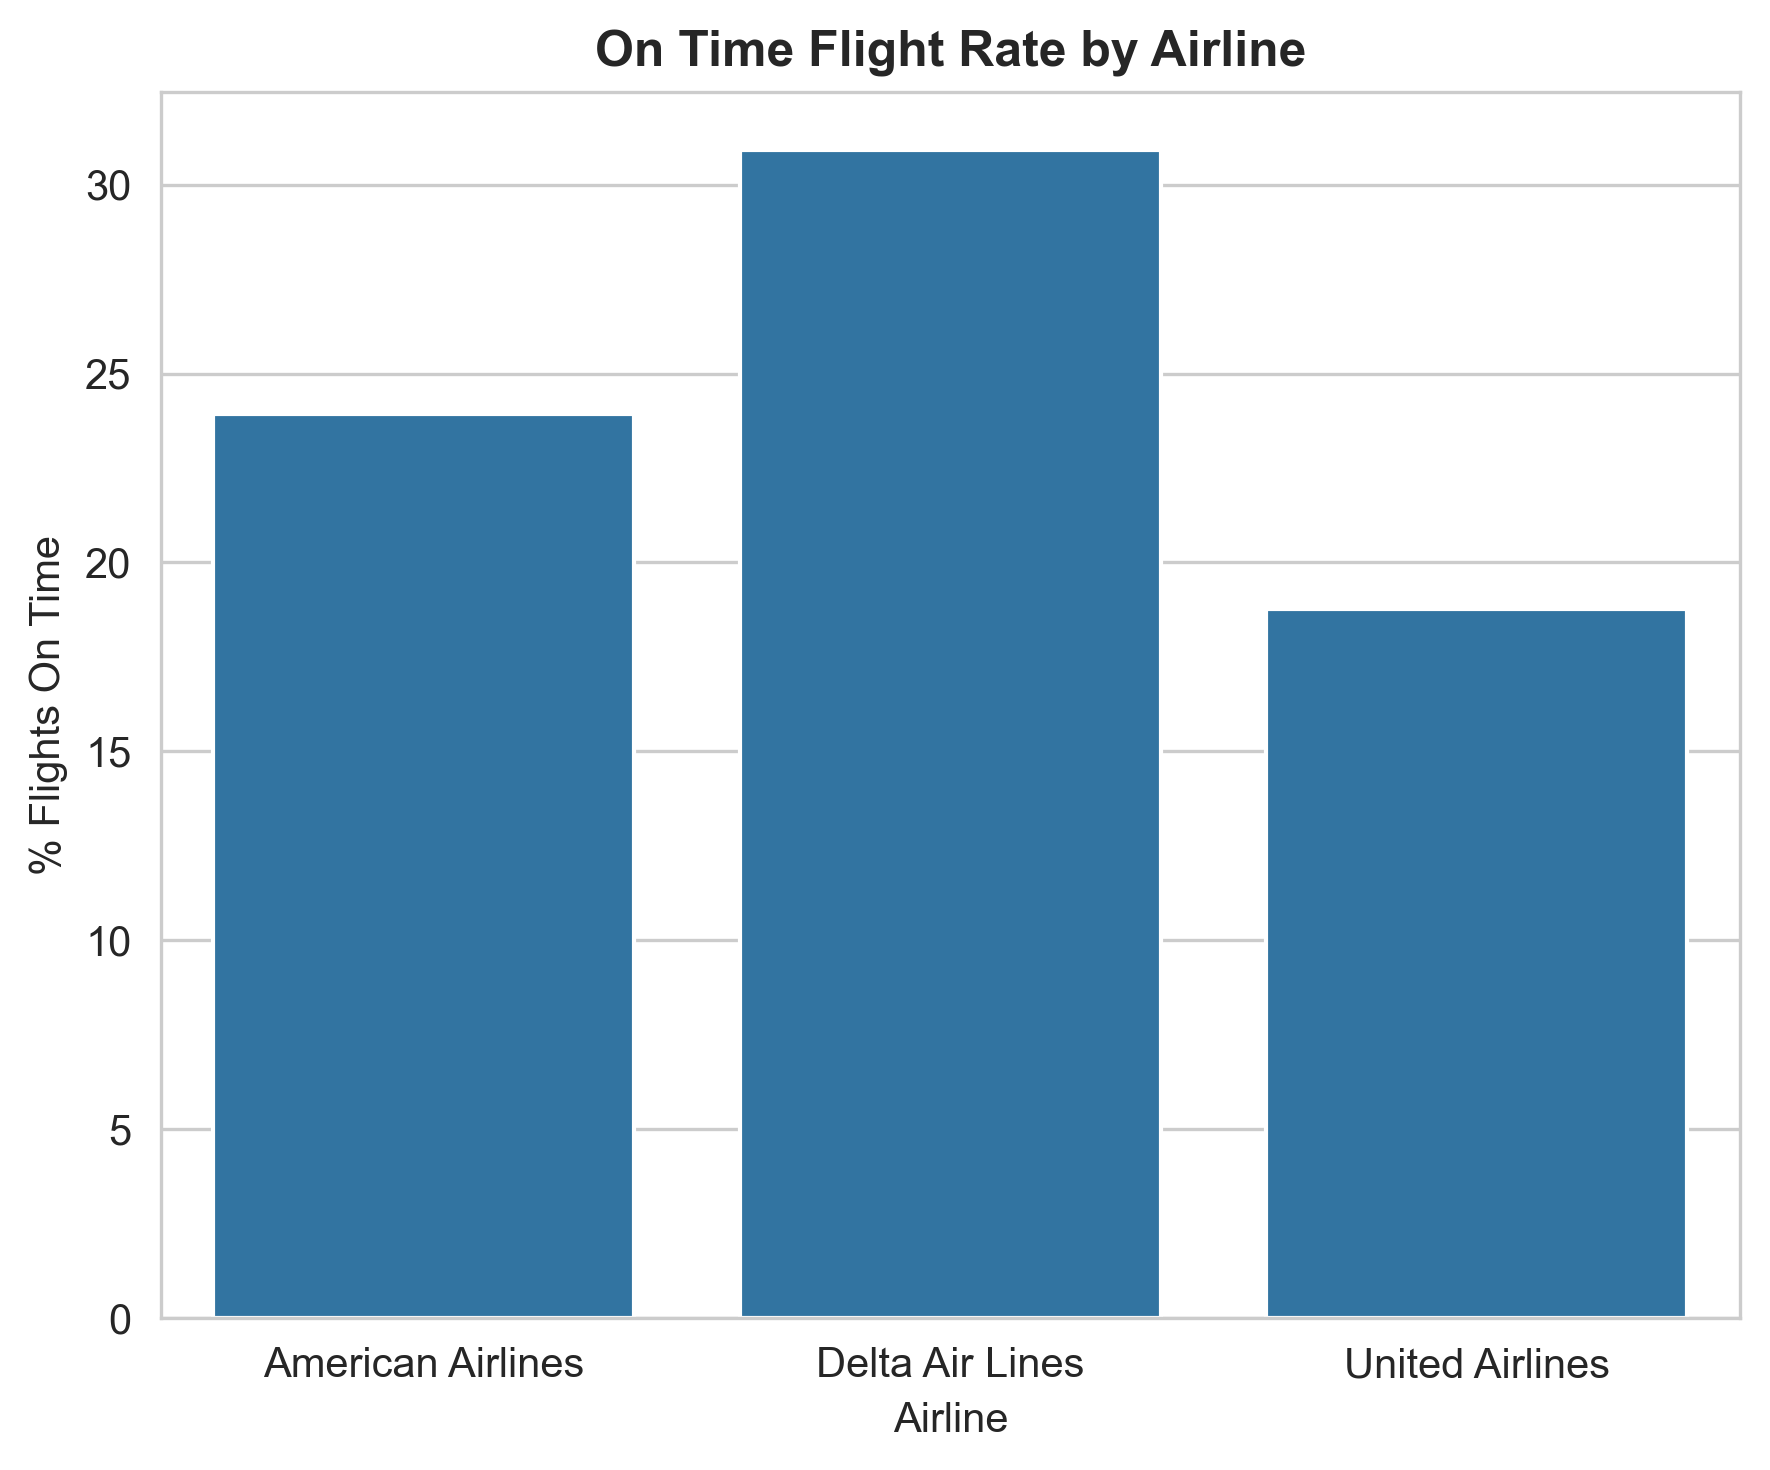

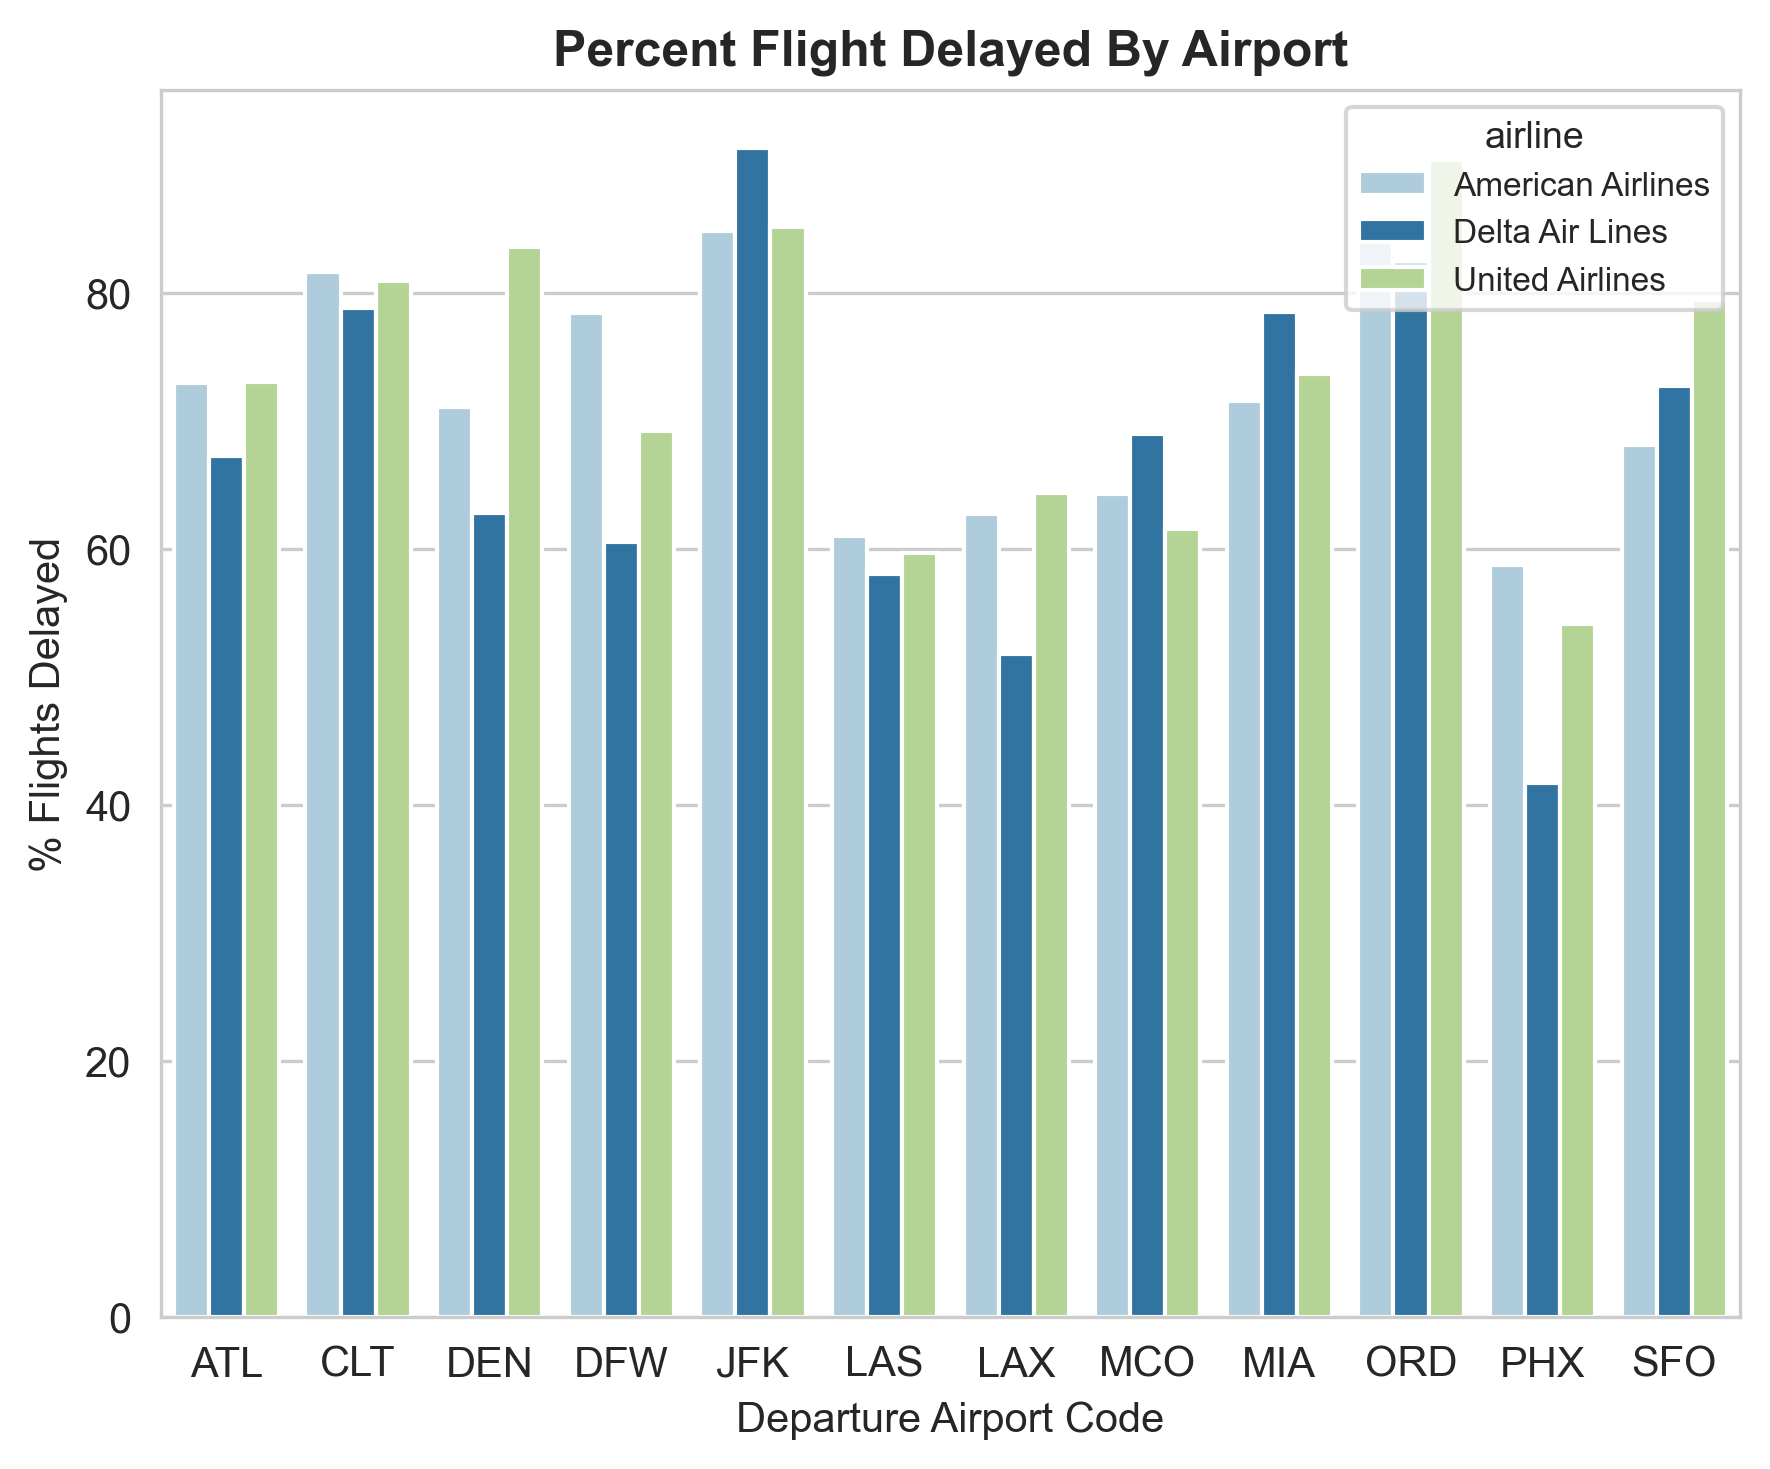

In [14]:
def plot_delay_metric(agg_df, x: str, y: str, x_title: str, y_title: str, plot_title: str, color_by: str = None, rotate_xticks: bool = True, palette: str = "Paired"):
    
    plt.figure(figsize=(6, 5), dpi=300) 
    sns.set_style("whitegrid")

    if color_by:
        ax = sns.barplot(data=agg_df, x=x, y=y, hue=color_by, palette=palette)
    else:
        ax = sns.barplot(data=agg_df, x=x, y=y, color=sns.color_palette(palette)[1])

    # Axis labels and title
    ax.set_xlabel(x_title, fontsize=10)
    ax.set_ylabel(y_title, fontsize=10)
    ax.set_title(plot_title, fontsize=12, weight='bold')

    # Move legend to top right and shrink text
    if color_by:
        plt.legend(
            title=color_by,
            loc='upper right',
            fontsize=8,
            title_fontsize=9,
            frameon=True
        )
    else:
        plt.legend([],[], frameon=False) 

    plt.tight_layout()
    plt.show()

plot_delay_metric(airline_delays, "airline", "pct_ontime", "Airline", "% Flights On Time", "On Time Flight Rate by Airline")
plot_delay_metric(depiata_airline_delays, "dep_iata", "pct_delay", "Departure Airport Code", "% Flights Delayed", "Percent Flight Delayed By Airport", color_by="airline")

In [15]:
def aggregate_flight_status(flights_df: pd.DataFrame, airline: str):
    
    """ 
    Outputs the total number of flights grouped by flight status (e.g. canceled, diverted, etc.) for an airline 
    Parameter:
        flights_df: flights dataframe
        airline: name of airline for filtering
    Returns:
        Aggregate dataframe showing the flight counts in each flight status for a specified airline 
    """

    # Filter for all flights flown by "airline"
    filtered_df = flights_df[flights_df["airline"] == airline]

    # Count the flights within each flight status
    agg_df = filtered_df.groupby("flight_status")["flight_status"].count().reset_index(name="flight_count")

    return agg_df

display(aggregate_flight_status(flights_df, "Delta Air Lines"))


,flight_status,flight_count
0,cancelled,810
1,diverted,91
2,landed,37403
3,pending update,12803
4,unknown,38


In [21]:
def cancelled_flights(flights_df: pd.DataFrame, airline: str):
    
    """ 
    Determine whether any particular departure location were more prone to cancellation
    Parameter:
        flights_df: flights dataframe
        airline: name of airline for filtering
    Return:
        Aggregate dataframe containing 
    """
    # Filter for cancelled flights and airline 
    cancelled_flights = flights_df[(flights_df["flight_status"] == "cancelled") & (flights_df["airline"] == airline)]
    
    agg_df = (cancelled_flights.groupby(["dep_iata", "dep_airport"])["flight_date"]
            .count()
            .reset_index(name='flight_count')
            .sort_values(by="flight_count", ascending = False)
    )

    return agg_df

display(cancelled_flights(flights_df, "Delta Air Lines"))
    

,dep_iata,dep_airport,flight_count
0,ATL,Hartsfield-jackson Atlanta International,393
4,JFK,John F Kennedy International,226
6,LAX,Los Angeles International,43
1,CLT,Charlotte Douglas,25
8,MIA,Miami International Airport,25
7,MCO,Orlando International,24
9,ORD,Chicago O'hare International,21
5,LAS,Mc Carran International,15
3,DFW,Dallas/Fort Worth International,12
11,SFO,San Francisco International,11


delay_bin,Early/On time,0–15 min,15–30 min,30–60 min,1–2 hrs,2+ hrs
dep_airport,,,,,,
Charlotte Douglas,0.000000,0.235546,0.427195,0.150964,0.098501,0.087794
Chicago O'hare International,0.000726,0.192447,0.379085,0.220770,0.135076,0.071895
Dallas/Fort Worth International,0.001889,0.419263,0.285175,0.135033,0.097262,0.061379
Denver International,0.001833,0.403300,0.299725,0.145738,0.087993,0.061412
Hartsfield-jackson Atlanta International,0.000229,0.363140,0.278528,0.176055,0.124838,0.057209
John F Kennedy International,0.000142,0.105203,0.333900,0.290940,0.171700,0.098114
Los Angeles International,0.001578,0.510848,0.269822,0.125444,0.061144,0.031164
Mc Carran International,0.004251,0.445271,0.308714,0.135494,0.064825,0.041445
Miami International Airport,0.000615,0.236017,0.387830,0.197296,0.100184,0.078058


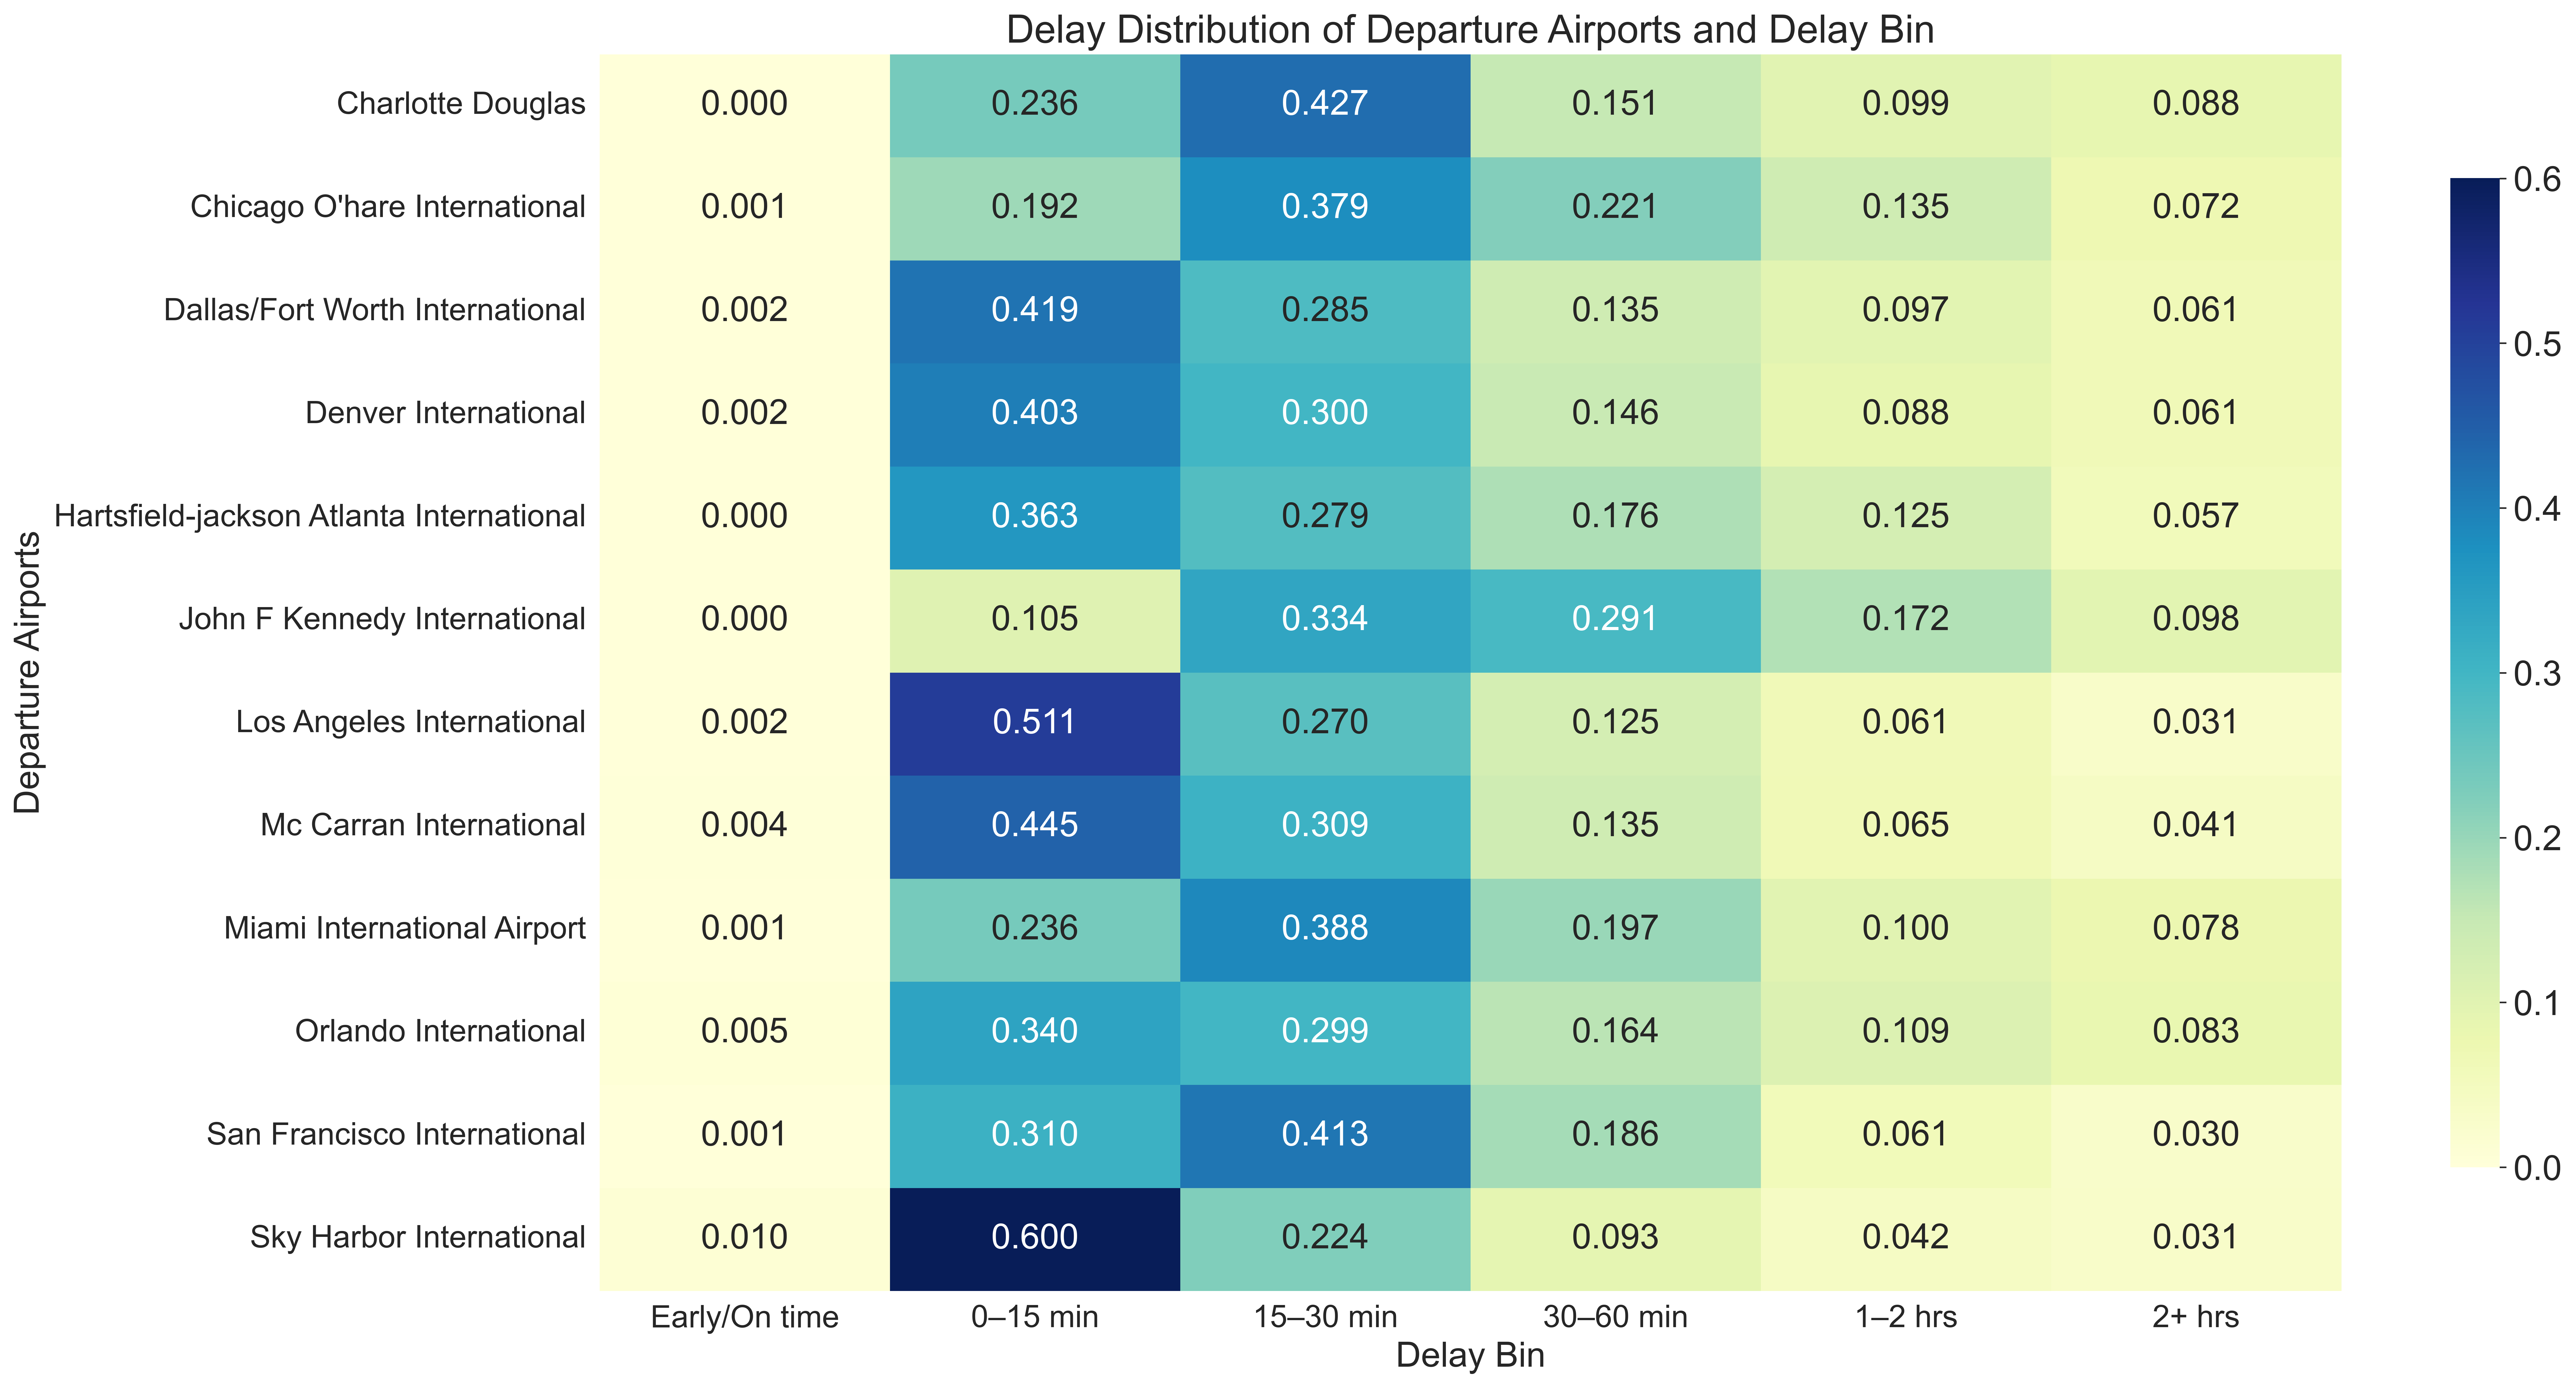

In [74]:
def delays_heatmap(flights_df: pd.DataFrame, var: str, var_name: str, airline: str, plot=False):

    """ 
    Delay comparison between different variables such as airline or day of week  
    Parameter:
        flights_df: flights dataframe
        var: categorical variable to use for comparison to delay_bin
        var_name: variable name to use for y axis labeling
        airline: filter by the airline 
        plot: plots the heatmap if True, otherwise False (default)
    Returns:
       Heatmap visualizing how flight proportions for a selected variable (like airline or day of week) are distributed across delay bins.
    """

    # Filter airline
    flights_copy = flights_df[flights_df["airline"] == airline].copy()

    # Define delay bins and labels
    bins = [-float("inf"), 0, 15, 30, 60, 120, float("inf")]
    labels = ["Early/On time", "0–15 min", "15–30 min", "30–60 min", "1–2 hrs", "2+ hrs"]

    # Categorize delay times
    flights_copy["delay_bin"] = pd.cut(flights_copy["dep_delay"], bins=bins, labels=labels, right=True)

    # Count and normalize
    delay_counts = flights_copy.groupby([var, "delay_bin"], observed=False).size().unstack(fill_value=0)
    airline_delay_proportions = delay_counts.div(delay_counts.sum(axis=1), axis=0)

    fig = None
    if plot:
        fig, ax = plt.subplots(figsize=(20, 10), dpi=500)
        sns.heatmap(
            airline_delay_proportions, 
            annot=True, 
            fmt=".3f", 
            cmap="YlGnBu", 
            annot_kws={"size": 18},
            cbar_kws={"shrink": 0.8},
            ax=ax
        )

        # Style tweaks
        ax.set_title(f'Delay Distribution of {var_name} and Delay Bin', fontsize=20)
        ax.set_xlabel("Delay Bin", fontsize=18)
        ax.set_ylabel(var_name, fontsize=18)
        ax.tick_params(axis='x', labelsize=16)
        ax.tick_params(axis='y', labelsize=16, rotation=0)

        # Enlarge colorbar ticks
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=18)

        fig.tight_layout()

    return airline_delay_proportions, fig

df, plot = delays_heatmap(flights_df, "dep_airport", "Departure Airports", "Delta Air Lines", plot=True)
display(df)

,dep_airport,mean_delay,delay_ratio
0,Charlotte Douglas,43.836188,1.116911
1,Chicago O'hare International,45.493827,1.159146
2,Dallas/Fort Worth International,36.110482,0.920066
3,Denver International,37.347388,0.951581
4,Hartsfield-jackson Atlanta International,38.470918,0.980208
5,John F Kennedy International,54.276833,1.382930
6,Los Angeles International,27.024063,0.688551
7,Mc Carran International,30.857067,0.786213
8,Miami International Airport,44.917640,1.144465
9,Orlando International,41.625425,1.060582


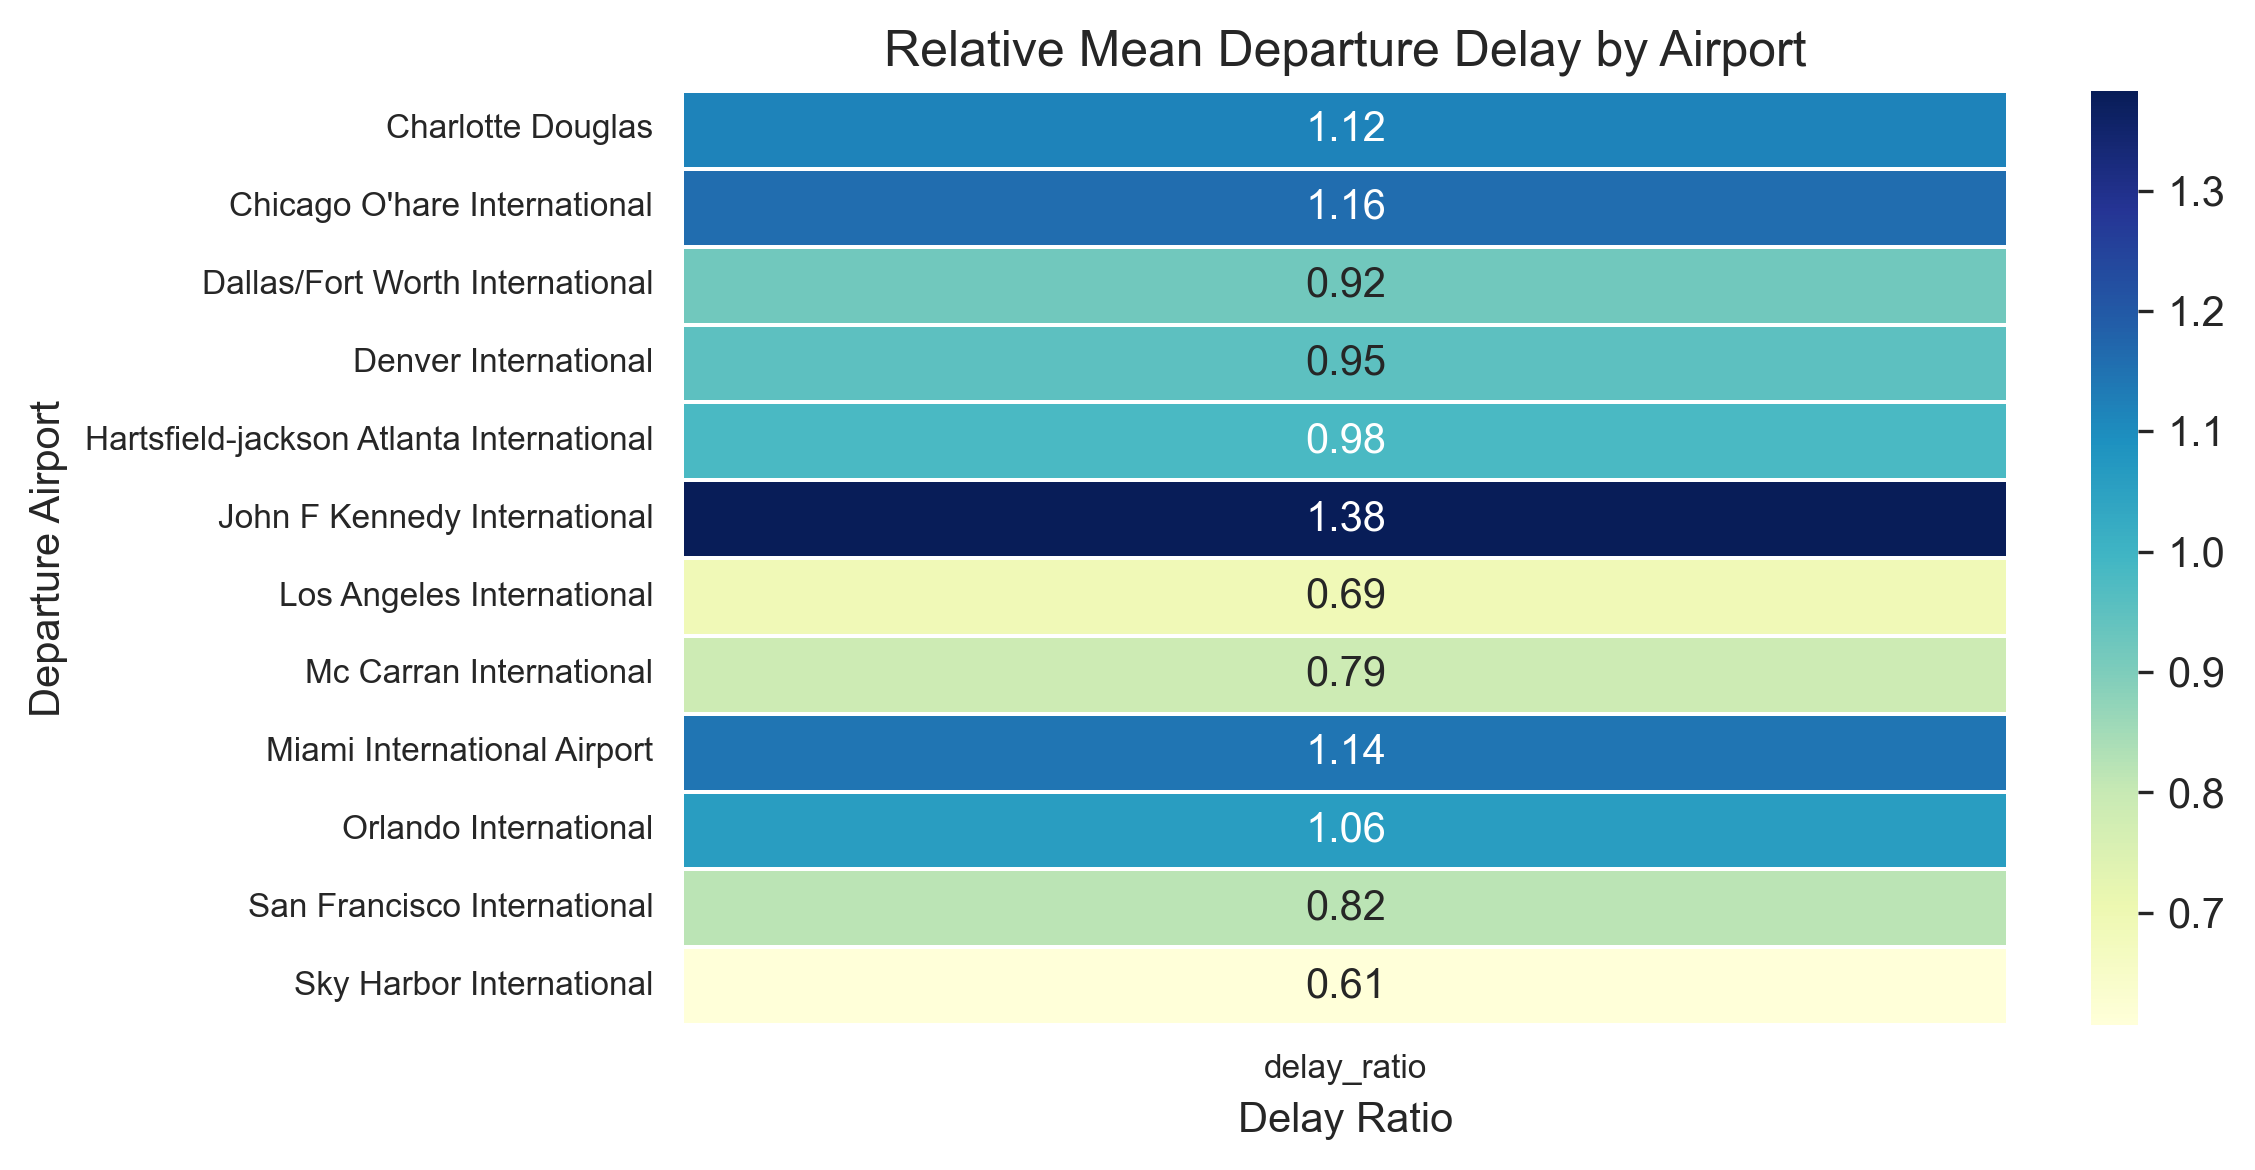

In [75]:
def relative_delay(flights_df: pd.DataFrame, airline: str, plot: bool = False):

    """ 
    Compare the relative mean delay per airport where > 1 airport has more delay than average and < 1 airport has less delay than average
    Parameters:
        flights_df: flights dataframe
        airline: filter by airline 
        plot: plots the heatmap if True, otherwise False (default)
    Returns:
        Heatmap comparing the relative delays for each airport
    """

    # Filter by airline
    flights_copy = flights_df[flights_df["airline"] == airline]

    # Calculate global mean delay
    global_mean = flights_copy["dep_delay"].mean()

    # Mean delay by airport
    mean_delay_by_airport = (
        flights_copy.groupby("dep_airport")["dep_delay"]
        .mean()
        .reset_index(name="mean_delay")
    )

    # Calculate ratio to global mean
    mean_delay_by_airport["delay_ratio"] = mean_delay_by_airport["mean_delay"] / global_mean

    fig = None
    # Plot
    if plot:
        fig, ax = plt.subplots(figsize=(8, 4), dpi=300)
        sns.heatmap(
            mean_delay_by_airport.set_index("dep_airport")[["delay_ratio"]],
            cmap='YlGnBu',
            annot=True,
            fmt=".2f",
            linewidths=0.5,
            ax=ax
        )
        plt.yticks(rotation=0, fontsize=8)
        plt.xticks(fontsize=8)
        plt.xlabel("Delay Ratio", fontsize=10)
        plt.ylabel("Departure Airport", fontsize=10)
        plt.title("Relative Mean Departure Delay by Airport", fontsize=12)
        plt.tight_layout()

    return mean_delay_by_airport, fig

df, plot = relative_delay(flights_df, "Delta Air Lines", True)
display(df)


In [35]:
def top_delayed_routes(flights_df: pd.DataFrame, airline: str, domestic: bool = True):

    """ 
    Find the top 10 delayed routes (delay > 60 mins) for routes with flight counts greater than the median of all destinations
    Parameter:
        flights_df: flights dataframe
        airline: filter by airline 
        domestic: set value to True (default) to view domestic flights only (US), otherwise False for international flights
    Returns:
        DataFrame containing dep_iata/airport, arr_iata/airport, and delay_rate for a specified departure location, 
        or for all departures if none is specified
    """
    
    # Filter by airline 
    flights_copy = flights_df[flights_df["airline"] == airline].copy()

    # Filter by domestic or international flights
    flights_copy = flights_copy[
        flights_copy["arr_country"] == "US" if domestic else flights_copy["arr_country"] != "US"
    ].copy()

    # Compute the delay_rate
    flights_copy["is_delayed"] = (flights_copy["dep_delay"] > 60).astype(int)
    route_df = (
        flights_copy
        .groupby(["dep_iata", "dep_airport", "arr_iata", "arr_airport"])
        .agg(
            flight_count=("flight_date", "count"),
            delay_count=("is_delayed", "sum")
        )
        .assign(delay_rate=lambda x: x["delay_count"] / x["flight_count"])
    )

    # Compute the median flight count
    median_flight_count = route_df["flight_count"].median()
    print(f"Only routes with flight counts greater than {median_flight_count} are included")

    # Filter routes with flight_count > median
    route_df = (
        route_df[route_df["flight_count"] > median_flight_count]
        .sort_values(by="delay_rate", ascending=False)
        .reset_index()
    )

    return route_df

top_delayed_routes(flights_df, "Delta Air Lines", False)

Only routes with flight counts greater than 28.0 are included


,dep_iata,dep_airport,arr_iata,arr_airport,flight_count,delay_count,delay_rate
0,ATL,Hartsfield-jackson Atlanta International,SCL,Arturo Merino Benitez,30,14,0.466667
1,JFK,John F Kennedy International,MXP,Milano Malpensa,48,22,0.458333
2,JFK,John F Kennedy International,MAD,Barajas,46,21,0.456522
3,ATL,Hartsfield-jackson Atlanta International,FRA,Frankfurt International Airport,29,13,0.448276
4,JFK,John F Kennedy International,GRU,Aeroporto Internacional Guarulhos,56,23,0.410714
...,...,...,...,...,...,...,...
104,LAX,Los Angeles International,AMS,Schiphol,52,0,0.000000
105,ATL,Hartsfield-jackson Atlanta International,AUA,Reina Beatrix,32,0,0.000000
106,ATL,Hartsfield-jackson Atlanta International,PLS,Providenciales International Airport,30,0,0.000000
107,SFO,San Francisco International,TPE,Taiwan Taoyuan International (Chiang Kai Shek ...,30,0,0.000000


## Column 2 

(1) Map showing the flights from any airline 
(2) Flight volume by hour 

In [36]:
def extract_hour(flights_df):
    
    flights_copy = flights_df.copy()
    flights_copy["scheduled_departure_datetime"] = pd.to_datetime(flights_copy["scheduled_departure_datetime"], errors="coerce")       
    flights_copy["hour"] = flights_copy["scheduled_departure_datetime"].dt.hour

    return flights_copy

flights_df = extract_hour(flights_df)

In [37]:
def peak_hour_delays(flights_df, airline: str):

    """ 
    Output the total delay minutes and flight counts of all airlines for each hour
    Allow for peak hour delay analysis  
    Parameters: 
        flights_df: flights dataframe
        airline: filter by the airline
    Returns:
        A dataframe with total delay times for domestic and international flights for each hour, and
        the total number of delayed flights for those hours
    """

    flights_copy = flights_df[flights_df["airline"] == airline].copy()

    # Create Domestic/International group
    flights_copy["country_group"] = np.where(flights_copy["arr_country"] == "US", "Domestic", "International")

    # Group by hour and country_group, sum delays
    grouped = flights_copy.groupby(["hour", "country_group"], observed=False)["dep_delay"].sum().unstack(fill_value=0)

    # Count the number of delayed flights for each hour (delayed_flights > 15 min)
    delayed_flights = flights_copy[flights_copy["dep_delay"] > 15]
    grouped_delayed_flights = delayed_flights.groupby("hour").size().reset_index(name="delayed_flight_count")

    # Merge dataframes
    merged_df = pd.merge(grouped, grouped_delayed_flights, on="hour")

    return merged_df

peak_hour_delays(flights_df, "Delta Air Lines")

,hour,Domestic,International,delayed_flight_count
0,0.0,3215.0,1537.0,94
1,1.0,887.0,2366.0,59
2,2.0,392.0,175.0,8
3,3.0,2.0,60.0,1
4,4.0,108.0,0.0,2
5,5.0,3244.0,0.0,55
6,6.0,16581.0,1117.0,343
7,7.0,40851.0,1006.0,906
8,8.0,41430.5,9876.0,1110
9,9.0,49547.5,9802.0,1299


In [38]:
def flight_volume_by_hour(flights_df: pd.DataFrame):

    """ 
    Show the distribution of flight volume for each airline by hour
    Parameters:
        flights_df: flights dataframe
    Returns:
        Aggregate dataframe with the columns airline, airline, and flight count
    """
    
    flights_copy = flights_df.copy()

    # Handling missing scheduled_departure_datetimes
    flights_copy["scheduled_departure_datetime"] = pd.to_datetime(
        flights_copy["scheduled_departure_datetime"], errors="coerce")       

    # Extract hour component from the departure datetime 
    flights_copy["hour"] = flights_copy["scheduled_departure_datetime"].dt.hour

    agg_df = flights_copy.groupby(["airline", "hour"]).size().reset_index(name="flight_count")

    return agg_df

flight_volume_by_hour(flights_df)

,airline,hour,flight_count
0,American Airlines,0.0,148
1,American Airlines,1.0,131
2,American Airlines,2.0,11
3,American Airlines,3.0,6
4,American Airlines,4.0,4
...,...,...,...
66,United Airlines,19.0,2246
67,United Airlines,20.0,1331
68,United Airlines,21.0,1314
69,United Airlines,22.0,598


In [ ]:
new_df = pd.read_csv("flights_df.csv")
new_df

/var/folders/f2/l608sl5535j9cmwb4x0rkr780000gn/T/ipykernel_70611/2788654756.py:1: DtypeWarning: Columns (8,9,10,11,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  new_df = pd.read_csv("flights_df.csv")


In [ ]:
def country_to_continent(country_name):
    import pycountry
    import pycountry_convert as pc 

    try:
        country_alpha2 = pycountry.countries.lookup(country_name).alpha_2
        continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        # Split USA from North America
        if country_name == "US":
            return "usa"
        return continent_name.lower()
    except:
        return "Other"
    
flights_df["region"] = flights_df["arr_country"].apply(country_to_continent)

flights_df

,flight_date,flight_number,flight_status,airline,dep_airport,dep_timezone,dep_iata,dep_delay,scheduled_departure_datetime,scheduled_departure_datetime_date,...,scheduled_arrival_datetime,scheduled_arrival_datetime_date,scheduled_arrival_datetime_time,actual_arrival_datetime,arr_latitude,arr_longitude,arr_country,arr_city,arr_state,region
0,2025-06-01,8970,pending update,Delta Air Lines,Hartsfield-jackson Atlanta International,America/New_York,ATL,10.0,2025-06-01 17:00:00,2025-06-01,...,2025-06-01 17:26:00,2025-06-01,17:26:00,NaT,32.500000,-93.666664,US,Bossier City,Louisiana,usa
1,2025-06-01,3594,pending update,Delta Air Lines,Hartsfield-jackson Atlanta International,America/New_York,ATL,6.0,2025-06-01 09:34:00,2025-06-01,...,2025-06-01 10:25:00,2025-06-01,10:25:00,NaT,32.445112,-93.826737,US,Shreveport,Louisiana,usa
2,2025-06-01,3033,pending update,Delta Air Lines,Hartsfield-jackson Atlanta International,America/New_York,ATL,16.0,2025-06-01 08:10:00,2025-06-01,...,2025-06-01 08:43:00,2025-06-01,08:43:00,NaT,34.727432,-92.221375,US,North Little Rock,Arkansas,usa
3,2025-06-01,3147,landed,Delta Air Lines,Hartsfield-jackson Atlanta International,America/New_York,ATL,9.0,2025-06-01 09:40:00,2025-06-01,...,2025-06-01 10:36:00,2025-06-01,10:36:00,2025-06-01 10:25:00,34.895446,-82.217228,US,Greer,South Carolina,usa
4,2025-06-01,9937,cancelled,Delta Air Lines,Hartsfield-jackson Atlanta International,America/New_York,ATL,23.0,2025-06-01 00:15:00,2025-06-01,...,2025-06-01 01:15:00,2025-06-01,01:15:00,NaT,32.845023,-96.849841,US,University Park,Texas,usa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194232,2025-06-30,9330,pending update,American Airlines,San Francisco International,America/Los_Angeles,SFO,7.0,NaT,None,...,NaT,None,None,NaT,33.830339,-116.509645,US,Palm Springs,California,usa
194233,2025-06-30,2410,pending update,American Airlines,San Francisco International,America/Los_Angeles,SFO,18.0,NaT,None,...,NaT,None,None,NaT,35.210741,-80.945744,US,None,None,usa
194234,2025-06-30,2799,pending update,American Airlines,San Francisco International,America/Los_Angeles,SFO,46.0,NaT,None,...,NaT,None,None,NaT,25.794979,-80.286723,US,Virginia Gardens,Florida,usa
194235,2025-06-30,3166,pending update,American Airlines,San Francisco International,America/Los_Angeles,SFO,10.0,NaT,None,...,NaT,None,None,NaT,39.875018,-75.235213,US,Colwyn,Pennsylvania,usa
